In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="USDT_BTC",
                  #start=string2ts("2017-10-01 00:00:00"),
                  start=1502427600,
                  end=string2ts("2018-04-18 01:45:00"),
                  period=3600/12)


per = 0.85
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
 

df["ho"] = df["high"]-df["open"]
df["lo"] = df["low"]-df["open"]

tf_1 = df.shift(-1)

#df["outcome"] = (tf_1["close"]>tf_1["open"])
df["outcome"] = (df["close"]>df["open"])


ts_1 = df.shift(1)
ts_2 = df.shift(2)
ts_3 = df.shift(3)

df["feat1"] = ts_1["close"] > ts_2["close"]
df["feat2"] = ts_2["close"] > ts_3["close"]

#df["feat1"] = df["close"] > ts_1["close"]
#df["feat2"] = df["close"] > ts_2["close"]

df["gain"] = df["close"] - df["open"]
#df["gain"] = (tf_1["close"] - tf_1["open"])

#df[["close", "open"]].head(16)

In [2]:
from stockstats import StockDataFrame
from profit import profit
from mldata import ml_data

df["ml_data"] = ml_data(df["close"],la=10,pl=False)

stock = StockDataFrame.retype(df.copy())

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"], "log_return":marketReturn(df["close"]), "feat1":df["feat1"], "feat2":df["feat2"], 
                          "ideal_w2":df["outcome"], "gain":df["gain"], "lo":df["lo"], "open":df["open"], "ideal":df["ml_data"]})


data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

fe2 = ["feat1", "feat2", "gain"]
features = ["feat1", "feat2", "rsi", "cci"]

train2, test2 = df[1:int(len(data)*per)], df[int(len(data)*per):]

X_train, y_train, X_test, y_test = train[features], train["ideal"], test[features], test["ideal"]


C:\Users\Daniel.LAPTOP-OBVONK0N\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf = XGBClassifier(n_estimators=9, learning_rate=0.75, gamma=12)

# solo cogiendo feat1 y feat2, no cogiendo gain
clf.fit(X_train, y_train)

pre_proba = clf.predict_proba(X_test)

pre = clf.predict(X_test)

accuracy_score(y_test, pre)

0.59755646057015921

In [4]:
def trade_with_stop(bar, fee = 0, stop=None):
    """
    Given a bar, with a gain obtained by the closing price - opening price
    it applies a stop limit order to limit a negative loss
    If stop is equal to None, then it returns bar['gain']
    """
    bar['gain'] = bar['gain']*(1-2*fee)
    if stop<>None:
        real_stop = (stop)*(1-2*fee)
        if bar['lo']<=-stop:
            #print "real_stop", -real_stop, "lo", bar["lo"], "gain", bar["gain"]
            return real_stop
    # stop == None    
    return bar['gain']

In [5]:
STOP = 50
threshold = 0.5
FEE = 0.0015

w = pd.DataFrame(data={"pre":pre ,"close":test["close"], "w_prob":pre_proba[:,1], "outcome":test2["outcome"]})

trades = test[w["pre"]==1][["gain", "close", "lo", "open"]]
trades["pnl"] = trades.apply(lambda x: trade_with_stop(x, FEE, STOP), axis=1)
pnl = test[w["pre"]==1]["gain"]

print "Profit:", pnl.cumsum()[-2]/w["close"][0]*100
print "Profit con FEE:", trades["pnl"].cumsum()[-2]/w["close"][0]*100
print "Número de trades:", len(pnl), "+razón de entrada:", float(len(pnl))/len(test)

Profit: 190.190443154
Profit con FEE: 313.273779446
Número de trades: 5917 +razón de entrada: 0.547667530544


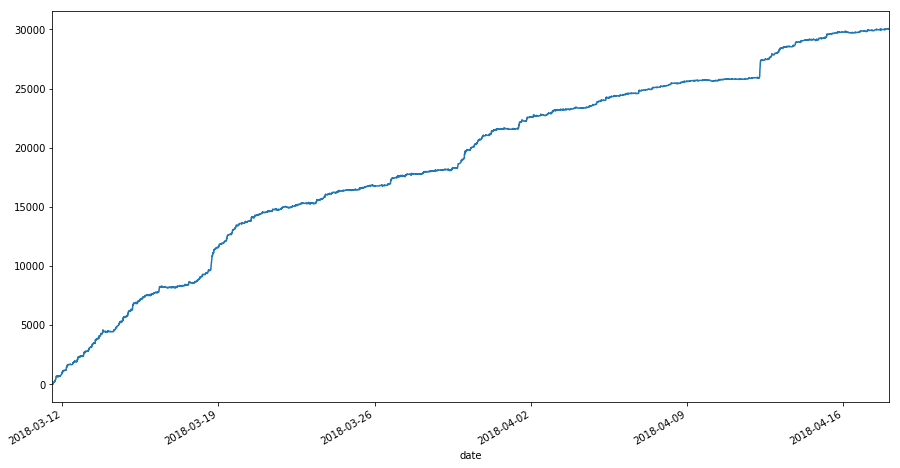

In [6]:
trades["pnl"].cumsum().plot()

In [7]:
pnl.cumsum()[-1]

18269.072753840013

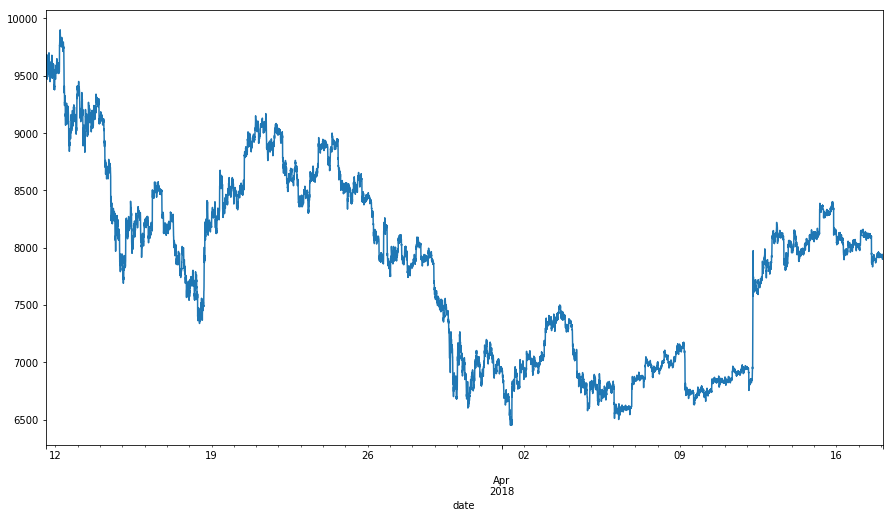

In [8]:
w["close"].plot()

In [9]:
data["feat2"].tail()

date
2018-04-18 01:25:00     True
2018-04-18 01:30:00    False
2018-04-18 01:35:00     True
2018-04-18 01:40:00    False
2018-04-18 01:45:00     True
Freq: 5T, Name: feat2, dtype: bool

In [10]:
w["pre"].tail()

date
2018-04-18 01:25:00    1
2018-04-18 01:30:00    1
2018-04-18 01:35:00    1
2018-04-18 01:40:00    0
2018-04-18 01:45:00    0
Freq: 5T, Name: pre, dtype: int64